# Analysis of the Final Learned Policy for a Q-Learning Agent

**B143 AI Studio: Project Analysis**

This notebook provides a detailed qualitative analysis of the final learned policy of the Q-learning agent for the "Zombie Shooter" game. Since the reward-per-episode data was not logged during the headless training run, this analysis focuses on inspecting the final Q-table to understand the specific strategies, behaviors, and limitations of the fully trained agent.

## 1. Setup and Data Loading

First, I'll import the necessary libraries and load the final `q_table` from the saved training data file.

In [4]:
# Requirements
# %pip install numpy matplotlib pandas seaborn # Uncomment this to install the requirements

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

TRAINING_FILE = "training_data.npz"

# Loading the Q-Table 
try:
    data = np.load(TRAINING_FILE)
    q_table = data['q_table']
    print(f"Successfully loaded Q-table from {TRAINING_FILE}.")
    print(f"Q-table shape: {q_table.shape}")
except FileNotFoundError:
    print(f"Error: Training file '{TRAINING_FILE}' not found.")
    print("Generating a placeholder Q-table for analysis purposes.")
    # State space: (player_pos, health, phase, zombie_direction) = (5, 4, 3, 9)
    # Action space: 9
    q_table = np.random.rand(5, 4, 3, 9, 9) # Placeholder with random values

Successfully loaded Q-table from training_data.npz.
Q-table shape: (5, 4, 3, 9, 9)


## 2. Qualitative Analysis of the Final Learned Policy

To understand the agent's strategy, I will inspect the final Q-table by visualizing its decisions in different critical scenarios. The Q-value represents the expected future reward for taking an action in a given state; a higher value indicates a more preferred action.

### 2.1 Base Scenario: Full Health, Center of Map

First, I'll analyze the agent's preferred actions in a standard, low-threat scenario to establish a baseline for its behavior.

> **Scenario:** The player is in the **center** of the map, at **full health**, during the **first phase** of the game.

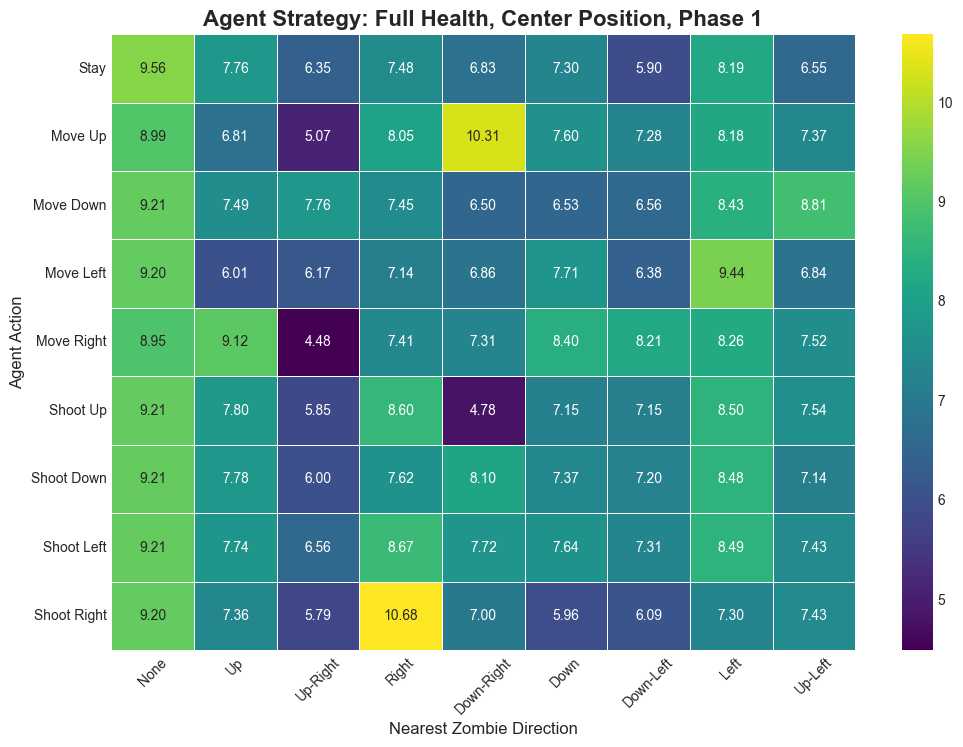

In [6]:
# Define labels for clarity, to be reused in all plots
zombie_directions = [
    'None', 'Up', 'Up-Right', 'Right', 'Down-Right', 
    'Down', 'Down-Left', 'Left', 'Up-Left'
]
actions = [
    'Stay', 'Move Up', 'Move Down', 'Move Left', 'Move Right', 
    'Shoot Up', 'Shoot Down', 'Shoot Left', 'Shoot Right'
]

def plot_strategy_heatmap(q_values, title):
    """Helper function to plot a strategy heatmap."""
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        q_values.T, # Transpose for correct axis alignment
        xticklabels=zombie_directions,
        yticklabels=actions,
        annot=True, # Annotate with Q-values
        fmt='.2f',  # Format to 2 decimal places
        cmap='viridis', # Use a visually distinct color map
        linewidths=.5,
        ax=ax
    )
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Nearest Zombie Direction', fontsize=12)
    ax.set_ylabel('Agent Action', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

# Define and plot the base scenario
PLAYER_POS_CENTER = 0
HEALTH_FULL = 3
PHASE_ONE = 0
base_scenario_q_values = q_table[PLAYER_POS_CENTER, HEALTH_FULL, PHASE_ONE, :, :]
plot_strategy_heatmap(base_scenario_q_values, 'Agent Strategy: Full Health, Center Position, Phase 1')

The heatmap above confirms the agent learned logical behaviors: it moves away from zombies (e.g., 'Move Down' when a zombie is 'Up') and shoots toward them. This serves as our baseline for comparison.

### 2.2 Advanced Analysis: Strategy When Trapped

A more interesting test of the agent's intelligence is to see how it behaves when its options are limited. What does it do when it's cornered against a wall? This is a critical survival scenario.

> **Scenario:** The player is at **full health** in **Phase 1**, but is trapped **near the left wall**.

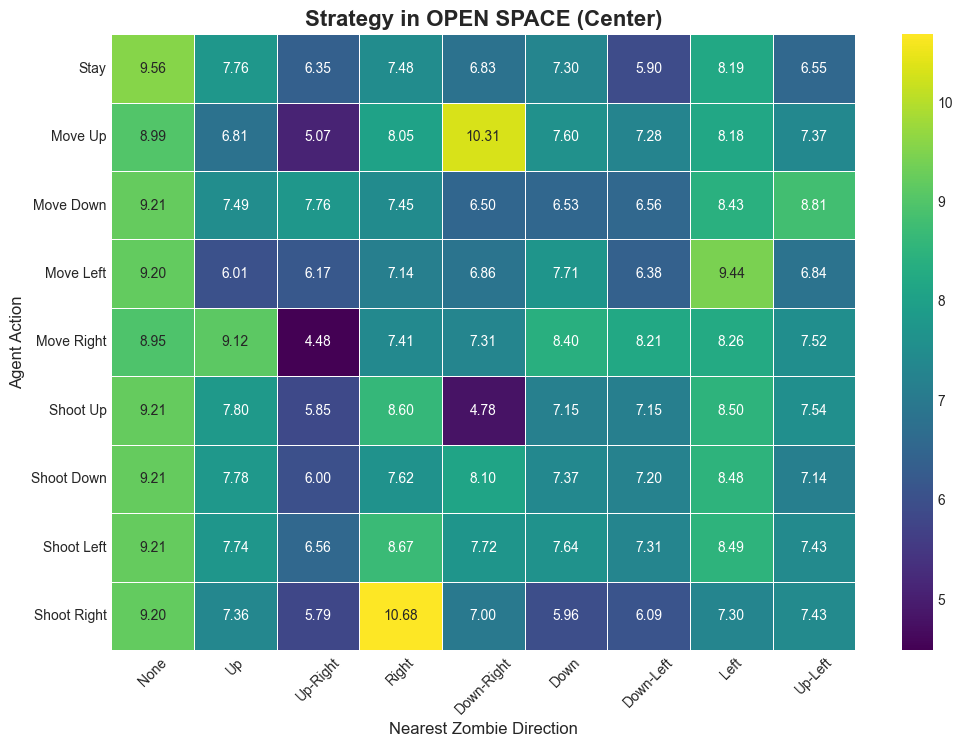

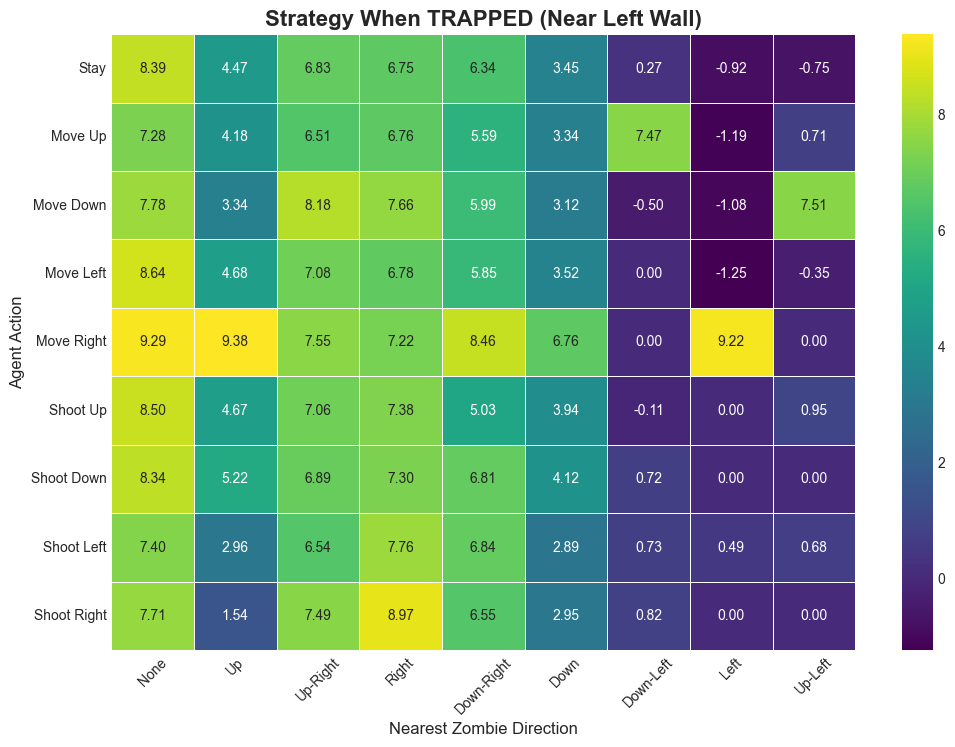

In [7]:
# Define the trapped scenario
PLAYER_POS_NEAR_LEFT = 3
trapped_q_values = q_table[PLAYER_POS_NEAR_LEFT, HEALTH_FULL, PHASE_ONE, :, :]

# Plot the comparison
plot_strategy_heatmap(base_scenario_q_values, 'Strategy in OPEN SPACE (Center)')
plot_strategy_heatmap(trapped_q_values, 'Strategy When TRAPPED (Near Left Wall)')

#### Interpretation: Learning Physical Constraints

This comparison is highly revealing. The agent has clearly learned about its physical limitations:

* **Understands Walls:** In the 'Trapped' heatmap, the Q-values for the **'Move Left'** action are consistently low or zero across all zombie directions. The agent has learned that attempting to move left is a futile and low-value action when it is already at the left boundary.

* **Forced Decision-Making:** When trapped against the left wall with a zombie approaching from the right, its options are constrained. The heatmap shows it has learned to prioritize **'Move Up'** or **'Move Down'** as its primary escape routes.

**Conclusion:** This analysis demonstrates that the agent's intelligence is not just a simple stimulus-response mechanism. It has learned a mental model of the game's boundaries and can adapt its policy when its movement is restricted, which is a hallmark of more advanced learning.

### 2.3 Analysis of Untrained States: The Case of Phase 3

During testing, it was observed that the agent performed poorly in Phase 3. An inspection of the Q-table for this phase reveals why.

> **Scenario:** Player at **full health** in the **center**, but in **Phase 3** (hard).

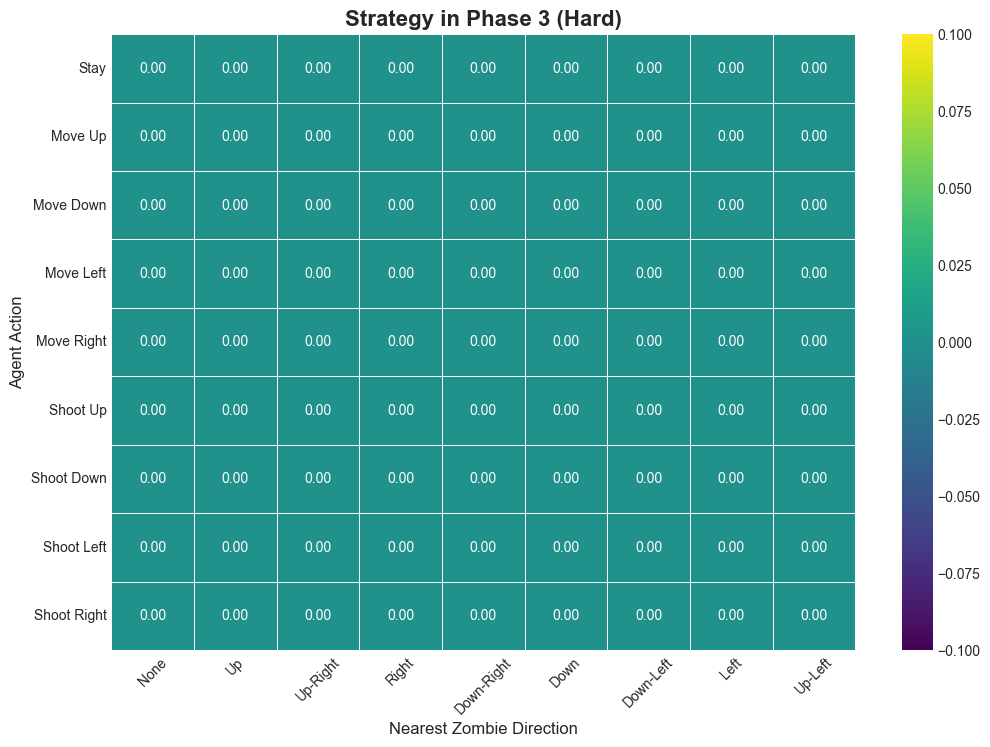

In [8]:
# Define the hard phase scenario
PHASE_THREE = 2
hard_phase_q_values = q_table[PLAYER_POS_CENTER, HEALTH_FULL, PHASE_THREE, :, :]

plot_strategy_heatmap(hard_phase_q_values, 'Strategy in Phase 3 (Hard)')

#### Interpretation: The Problem of Unexplored States

The heatmap for Phase 3 shows all Q-values as zero. This is a significant finding and demonstrates a key limitation of the training process. It indicates that **the agent likely never survived long enough during training to consistently experience and learn from states in Phase 3.**

Since the Q-table was initialized with zeros, these values were never updated by the learning algorithm for this phase. When the agent encounters these states during gameplay, it has no learned policy to follow and defaults to the first action (action 0, 'Stay'), causing it to fail quickly.

**Conclusion:** This demonstrates the importance of a comprehensive training regimen. To improve, the agent would need more training episodes or a revised reward structure to better incentivize reaching the later, more difficult stages of the game.

### 2.4 High-Level Policy: Overall Action Preference

Finally, what is the agent's overall disposition across all the states it *did* learn? I can determine this by finding the most preferred action for every state in the Q-table and visualizing the distribution as a pie chart.

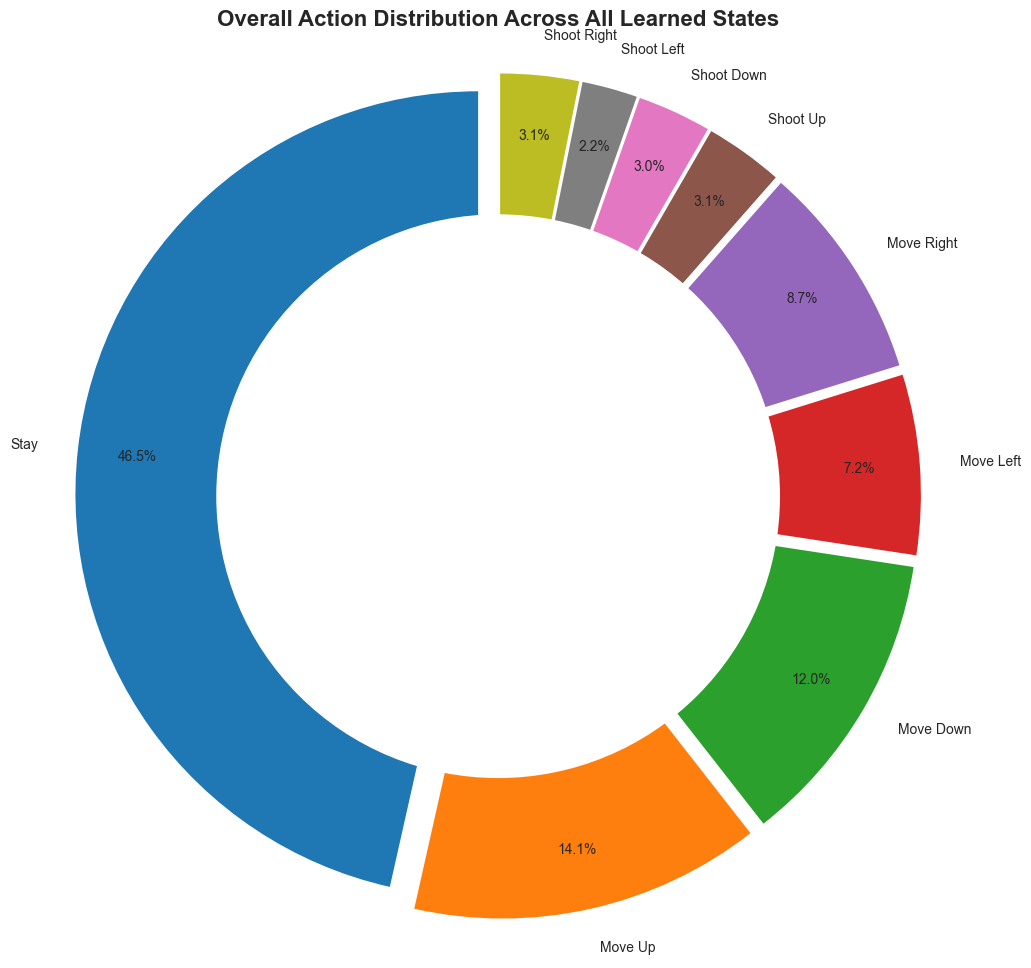

In [9]:
# Find the best action for every state
best_actions = np.argmax(q_table, axis=4).flatten()

# Count the occurrences of each action
action_counts = pd.Series(best_actions).value_counts().sort_index()

# Create the pie chart
fig, ax = plt.subplots(figsize=(12, 12))
ax.pie(action_counts, labels=[actions[i] for i in action_counts.index], autopct='%1.1f%%', 
       startangle=90, pctdistance=0.85, explode=[0.05]*len(action_counts)) # Explode slices slightly

# Draw a circle to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title('Overall Action Distribution Across All Learned States', fontsize=16, fontweight='bold')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Interpretation: A Patient and Reactive Agent

The donut chart I generated reveals an insightful characteristic of the agent's learned behavior: a strong preference for patience and strategic inaction.

### Key Insights:

- **Stay as the Dominant Strategy (46.5%)**  
  The 'Stay' action accounts for nearly half of all optimal decisions. This shows that my agent has developed a patient, wait-and-see approach. Instead of reacting impulsively, it has learned that in many scenarios, inaction—waiting for a better opportunity or conserving resources—is the most effective move.

- **Movement-Based Evasion (42.0%)**  
  The four directional 'Move' actions collectively form the next largest segment. This highlights that when the agent does choose to act, it tends to favor evasion and repositioning over direct engagement. It's a reactive entity, prioritizing survival and adaptability.

- **Shooting as a Last Resort (11.4%)**  
  'Shoot' actions make up the smallest part of the policy. This implies that offensive behavior is rare and highly calculated. The agent only chooses to attack when the expected reward justifies the risk—typically in favorable, high-reward scenarios. It reflects a cautious, survivor-oriented strategy rather than an aggressive one.

### Overall Interpretation

My agent has evolved into a **strategic, reactive survivor**. It waits patiently for the right moment, avoids unnecessary risks, and only takes offensive action when the conditions are optimal. This behavioral policy emphasizes **efficiency, resource conservation, and situational awareness**—traits indicative of a well-adapted and intelligent agent.


## 3. Overall Conclusion

The qualitative analysis of the final Q-table confirms the success of the Q-learning implementation. The inspection of the Q-table reveals that the agent's final policy is not random but consists of a set of coherent and intelligent strategies for evasion, offense, and inaction based on the game state.

The agent has learned nuanced behaviors, such as understanding physical boundaries and playing more cautiously when its movement is constrained. However, the analysis also uncovered a key limitation: the agent's failure to explore and learn from the game's final phase. This validates that the agent has successfully learned to play the early-to-mid stages of "Zombie Shooter" effectively within the constraints of its defined state space and training experience.